## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
import numpy as np

a = np.arange(50000)
np.random.shuffle(a)
indexs = a[:5000]

x_train = x_train[indexs]
y_train = y_train[indexs]

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [14]:
import tensorflow as tf
x = tf.constant([[1, 220, 55], [4, 3, -1]])
x_max = tf.reduce_max(x, axis=[1])
print(x_max)

tf.Tensor([220   4], shape=(2,), dtype=int32)


In [15]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(ce_weight, gamma=2., alpha=4.):
    
    gamma = float(gamma)
    alpha = float(alpha)
    
    """Define the customized loss."""
    def combined_loss_keras(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_ce = tf.reduce_max(ce, axis=1) # not sure if this line is necessary
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        
        return reduced_ce * ce_weight + (1-ce_weight) * reduced_fl
    
    return combined_loss_keras

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [17]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (B

5000/5000 [==============================] - 1s 240us/step - loss: 2.0264 - accuracy: 0.6964 - val_loss: 5.1349 - val_accuracy: 0.2507
Epoch 12/25
5000/5000 [==============================] - 1s 245us/step - loss: 1.8459 - accuracy: 0.7274 - val_loss: 5.0848 - val_accuracy: 0.2647
Epoch 13/25
5000/5000 [==============================] - 1s 266us/step - loss: 1.6997 - accuracy: 0.7572 - val_loss: 5.0258 - val_accuracy: 0.2789
Epoch 14/25
5000/5000 [==============================] - 1s 266us/step - loss: 1.5538 - accuracy: 0.7824 - val_loss: 4.9797 - val_accuracy: 0.2838
Epoch 15/25
5000/5000 [==============================] - 2s 309us/step - loss: 1.4282 - accuracy: 0.8040 - val_loss: 4.9344 - val_accuracy: 0.2906
Epoch 16/25
5000/5000 [==============================] - 2s 393us/step - loss: 1.3173 - accuracy: 0.8248 - val_loss: 4.8975 - val_accuracy: 0.2954
Epoch 17/25
5000/5000 [==============================] - 2s 374us/step - loss: 1.1983 - accuracy: 0.8444 - val_loss: 4.8700 - val_

Train on 5000 samples, validate on 10000 samples
Epoch 1/25
5000/5000 [==============================] - 3s 554us/step - loss: 5.1302 - accuracy: 0.1166 - val_loss: 3.9009 - val_accuracy: 0.1058
Epoch 2/25
5000/5000 [==============================] - 1s 251us/step - loss: 3.9848 - accuracy: 0.2352 - val_loss: 3.7806 - val_accuracy: 0.1244
Epoch 3/25
5000/5000 [==============================] - 1s 236us/step - loss: 3.3735 - accuracy: 0.3140 - val_loss: 3.6786 - val_accuracy: 0.1772
Epoch 4/25
5000/5000 [==============================] - 1s 246us/step - loss: 2.9655 - accuracy: 0.3668 - val_loss: 3.6019 - val_accuracy: 0.1979
Epoch 5/25
5000/5000 [==============================] - 1s 217us/step - loss: 2.6705 - accuracy: 0.4124 - val_loss: 3.5615 - val_accuracy: 0.1989
Epoch 6/25
5000/5000 [==============================] - 1s 230us/step - loss: 2.4354 - accuracy: 0.4534 - val_loss: 3.5551 - val_accuracy: 0.1928
Epoch 7/25
5000/5000 [==============================] - 1s 240us/step - los

5000/5000 [==============================] - 2s 365us/step - loss: 0.9864 - accuracy: 0.7130 - val_loss: 1.9665 - val_accuracy: 0.3297
Epoch 22/25
5000/5000 [==============================] - 2s 399us/step - loss: 0.9574 - accuracy: 0.7228 - val_loss: 1.9570 - val_accuracy: 0.3332
Epoch 23/25
5000/5000 [==============================] - 2s 326us/step - loss: 0.9295 - accuracy: 0.7358 - val_loss: 1.9480 - val_accuracy: 0.3338
Epoch 24/25
5000/5000 [==============================] - 2s 340us/step - loss: 0.8998 - accuracy: 0.7506 - val_loss: 1.9391 - val_accuracy: 0.3358
Epoch 25/25
5000/5000 [==============================] - 2s 323us/step - loss: 0.8742 - accuracy: 0.7620 - val_loss: 1.9295 - val_accuracy: 0.3369


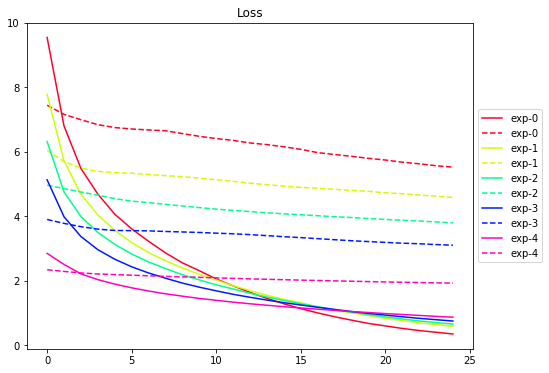

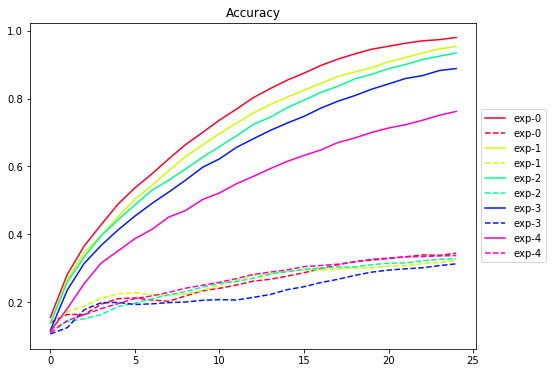

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()